In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
# Merge actigraph data
condition_folder = "data/condition"

In [3]:
# Function to load data from condition CSV files
def load_condition_data(condition_folder):
    condition_data = pd.DataFrame()
    for file in os.listdir(condition_folder):
        if file.endswith(".csv"):
            condition_number = os.path.splitext(file)[
                0
            ]  # Extract condition number from filename
            file_path = os.path.join(condition_folder, file)
            data = pd.read_csv(file_path)
            data["condition_number"] = (
                condition_number  # Add a column to identify the condition number
            )
            condition_data = pd.concat([condition_data, data], ignore_index=True)
    return condition_data

In [4]:
# Load condition data
condition_data = load_condition_data(condition_folder)
condition_data.head()

,timestamp,date,activity,condition_number
0,2002-06-06 13:00:00,2002-06-06,161,condition_23
1,2002-06-06 13:01:00,2002-06-06,80,condition_23
2,2002-06-06 13:02:00,2002-06-06,175,condition_23
3,2002-06-06 13:03:00,2002-06-06,728,condition_23
4,2002-06-06 13:04:00,2002-06-06,911,condition_23


In [5]:
# Reorder rows in ascending order
condition_data["condition_number"] = (
    condition_data["condition_number"].str.split("_").str[-1].astype(int)
)
condition_data = condition_data.sort_values(by="condition_number")
condition_data["condition_number"] = "condition_" + condition_data[
    "condition_number"
].astype(str)
condition_data.reset_index(drop=True, inplace=True)
condition_data.head()

,timestamp,date,activity,condition_number
0,2003-05-19 05:11:00,2003-05-19,0,condition_1
1,2003-05-23 11:08:00,2003-05-23,0,condition_1
2,2003-05-23 11:07:00,2003-05-23,0,condition_1
3,2003-05-23 11:06:00,2003-05-23,0,condition_1
4,2003-05-23 11:05:00,2003-05-23,0,condition_1


In [6]:
# Merge condition_data with scores.csv and perform some trivial imputation(s)
scores_file = "data/scores.csv"
scores_data = pd.read_csv(scores_file)
scores_data.head()

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


In [7]:
# Drop rows where the 'number' column starts with 'control_'
scores_data = scores_data[~scores_data["number"].str.startswith("control_")]

# Reset index
scores_data.reset_index(drop=True, inplace=True)

scores_data.head()

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,condition_2,18,2,40-44,1.0,2.0,2.0,6-10,2.0,2.0,24.0,11.0
2,condition_3,13,1,45-49,2.0,2.0,2.0,6-10,2.0,2.0,24.0,25.0
3,condition_4,13,2,25-29,2.0,2.0,2.0,11-15,1.0,1.0,20.0,16.0
4,condition_5,13,2,50-54,2.0,2.0,2.0,11-15,2.0,2.0,26.0,26.0


In [8]:
# Merge condition_data with scores_data using the 'number' column
condition_data_merged = pd.merge(
    condition_data,
    scores_data,
    left_on="condition_number",
    right_on="number",
    how="inner",
)

# Drop 'number' column
condition_data_merged = condition_data_merged.drop("number", axis=1)

# Display the merged data
condition_data_merged.head()

,timestamp,date,activity,condition_number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
0,2003-05-19 05:11:00,2003-05-19,0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
1,2003-05-23 11:08:00,2003-05-23,0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
2,2003-05-23 11:07:00,2003-05-23,0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
3,2003-05-23 11:06:00,2003-05-23,0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0
4,2003-05-23 11:05:00,2003-05-23,0,condition_1,11,2,35-39,2.0,2.0,2.0,6-10,1.0,2.0,19.0,19.0


In [9]:
# Check for null values
condition_data_merged.isnull().any()

timestamp           False
date                False
activity            False
condition_number    False
days                False
gender              False
age                 False
afftype             False
melanch              True
inpatient           False
edu                 False
marriage            False
work                False
madrs1              False
madrs2              False
dtype: bool

In [10]:
# Replace NaN and 3.0 values in the 'melanch' column with a 2.0 (Indicating no melancholia)
condition_data_merged["melanch"] = (
    condition_data_merged["melanch"].fillna(2.0).replace(3.0, 0.0)
)
condition_data_merged.isnull().any()

timestamp           False
date                False
activity            False
condition_number    False
days                False
gender              False
age                 False
afftype             False
melanch             False
inpatient           False
edu                 False
marriage            False
work                False
madrs1              False
madrs2              False
dtype: bool

In [11]:
# Correlational Analysis
condition_corr = condition_data_merged[["activity", "madrs1", "madrs2"]].corr()
print("Correlation Matrix within the Condition Group:")
condition_corr

Correlation Matrix within the Condition Group:


,activity,madrs1,madrs2
activity,1.000000,0.020423,0.016807
madrs1,0.020423,1.000000,0.600314
madrs2,0.016807,0.600314,1.000000


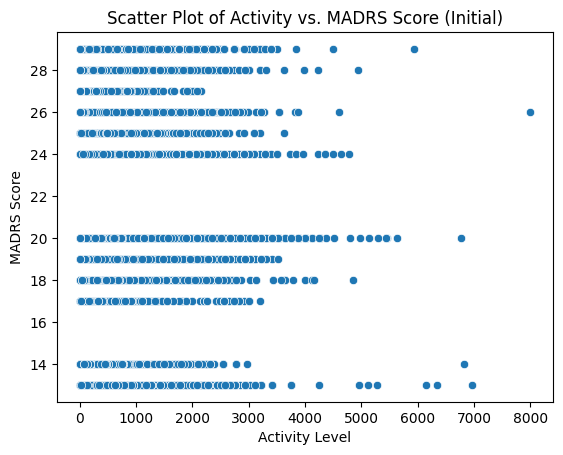

In [12]:
# Scatter Plot
sns.scatterplot(data=condition_data_merged, x="activity", y="madrs1")
plt.title("Scatter Plot of Activity vs. MADRS Score (Initial)")
plt.xlabel("Activity Level")
plt.ylabel("MADRS Score")
plt.show()

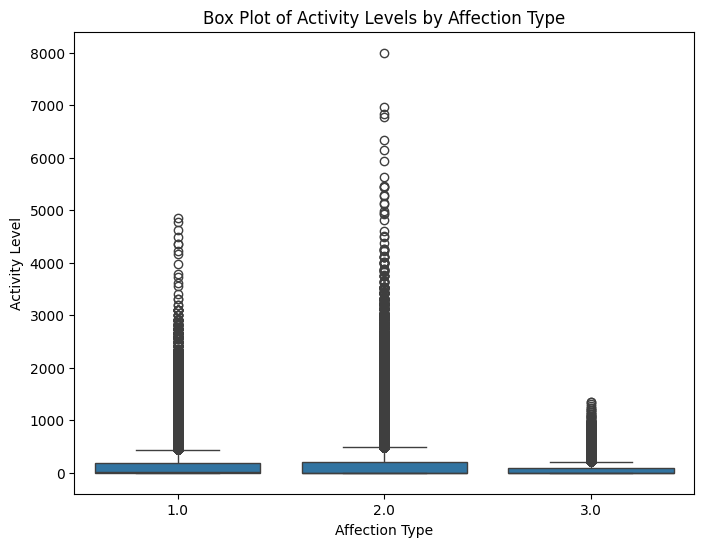

In [13]:
# Group Comparisons - Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=condition_data_merged, x="afftype", y="activity")
plt.title("Box Plot of Activity Levels by Affection Type")
plt.xlabel("Affection Type")
plt.ylabel("Activity Level")
plt.show()

In [14]:
print(condition_data_merged["age"].unique())
print(condition_data_merged["edu"].unique())

['35-39' '40-44' '45-49' '25-29' '50-54' '20-24' '60-64' '55-59' '30-34'
 '65-69']
['6-10' '11-15' '16-20' ' ']


In [15]:
# One-hot encode the age groups
age_encoded = pd.get_dummies(condition_data_merged["age"], prefix="age")

# One-hot encode the education groups
edu_encoded = pd.get_dummies(condition_data_merged["edu"], prefix="edu")

In [16]:
# Concatenate the encoded age and education groups with the original DataFrame
condition_data_merged_encoded = pd.concat(
    [condition_data_merged, age_encoded, edu_encoded], axis=1
)

In [17]:
# Drop the original 'age' and 'edu' columns
condition_data_merged_encoded.drop(["age", "edu"], axis=1, inplace=True)

In [18]:
condition_data_merged_encoded.columns

Index(['timestamp', 'date', 'activity', 'condition_number', 'days', 'gender',
       'afftype', 'melanch', 'inpatient', 'marriage', 'work', 'madrs1',
       'madrs2', 'age_20-24', 'age_25-29', 'age_30-34', 'age_35-39',
       'age_40-44', 'age_45-49', 'age_50-54', 'age_55-59', 'age_60-64',
       'age_65-69', 'edu_ ', 'edu_11-15', 'edu_16-20', 'edu_6-10'],
      dtype='object')

In [19]:
# Regression Analysis

# Features
X = condition_data_merged_encoded[
    [
        "activity",
        "days",
        "gender",
        "age_20-24",
        "age_25-29",
        "age_30-34",
        "age_35-39",
        "age_40-44",
        "age_45-49",
        "age_50-54",
        "age_55-59",
        "age_60-64",
        "age_65-69",
        "afftype",
        "melanch",
        "inpatient",
        "edu_ ",
        "edu_11-15",
        "edu_16-20",
        "edu_6-10",
        "marriage",
        "work",
    ]
]

# Target
y = condition_data_merged_encoded[
    "madrs1"
]  # or 'madrs2' depending on the target variable

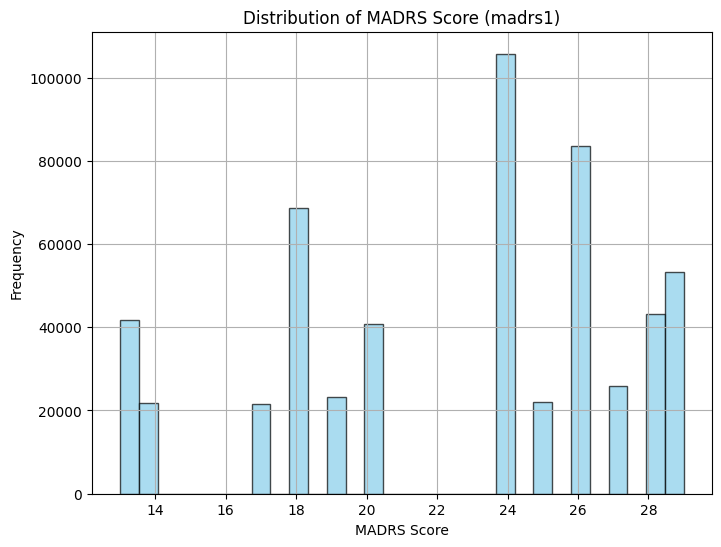

In [20]:
# Plot distribution of the target variable
plt.figure(figsize=(8, 6))
plt.hist(y, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
plt.title("Distribution of MADRS Score (madrs1)")
plt.xlabel("MADRS Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [21]:
# Define preprocessing steps

# Numeric Columns
numeric_cols = ["activity", "days"]

# Categorical Columns
categorical_cols = [
    "age_20-24",
    "age_25-29",
    "age_30-34",
    "age_35-39",
    "age_40-44",
    "age_45-49",
    "age_50-54",
    "age_55-59",
    "age_60-64",
    "age_65-69",
    "edu_ ",
    "edu_11-15",
    "edu_16-20",
    "edu_6-10",
    "gender",
    "afftype",
    "melanch",
    "inpatient",
    "marriage",
    "work",
]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

In [22]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [23]:
# Apply preprocessing to the dataframe
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed

array([[-0.50830388, -0.73419367,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.50830388, -0.73419367,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.50830388, -0.73419367,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.50830388,  1.06102533,  1.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.37376381,  1.06102533,  1.        , ...,  1.        ,
         0.        ,  1.        ],
       [-0.00649152,  1.06102533,  1.        , ...,  1.        ,
         0.        ,  1.        ]])

In [24]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, random_state=42
)

In [25]:
# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [26]:
# Make predictions
y_pred = model.predict(X_test)
y_pred

array([16.50585938, 26.99804688, 18.00146484, ..., 28.33740234,
       14.        , 13.9921875 ])

In [27]:
# Evaluate model
print("\nLinear Regression Model Performance:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R-squared:", r2_score(y_test, y_pred))


Linear Regression Model Performance:
Mean Squared Error: 1.1464024342351833
R-squared: 0.9528108714268541


In [28]:
X_test.shape

(110344, 43)

In [32]:
y_test.shape

(110344,)

In [29]:
y_pred.shape

(110344,)

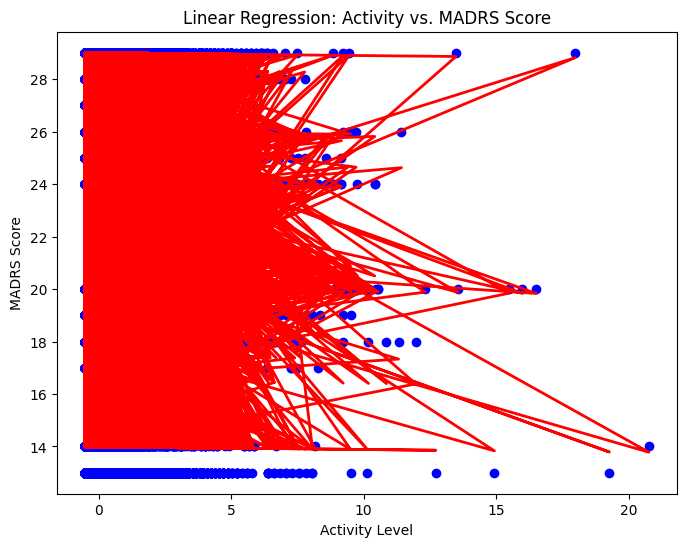

In [30]:
# Regression Line(s)
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], y_test, color="blue")
plt.plot(X_test[:, 0], y_pred, color="red", linewidth=2)
plt.title("Linear Regression: Activity vs. MADRS Score")
plt.xlabel("Activity Level")
plt.ylabel("MADRS Score")
plt.show()

In [31]:
"""
Linear Regression Model Performance:
Mean Squared Error: 1.1465350128037757
R-squared: 0.9528054141223923
"""

'\nLinear Regression Model Performance:\nMean Squared Error: 1.1465350128037757\nR-squared: 0.9528054141223923\n'